<h2>User Inputs:</h2>
 1. Expression, 2. Label, 3. Image

In [1]:
#user_input = "Help me segment the person in red and the left cat in this image"
#user_input = "Help me segment the right person and the left cat in this image"
#user_input = "Help me segment the cyan ball in this image"
#user_input = "help me segment the person in blue in this image"
#user_input = "help me segment the cat and dog in this image"
user_input = "person in a cap"
label = "person"


#img_path = 'inputs/cat2.jpeg'
#img_path = 'inputs/ADE_val_00000297.jpg'
#img_path = 'inputs/IMG_7487_smaller.jpg'
#img_path = "inputs/ball.jpg"
img_path = "inputs/ADE_val_00000110.jpg"
#img_path = "inputs/outfits.jpg"
#img_path = "inputs/cats-and-dogs.jpg"


<h3> Initialize LSeg </h3>
Dataset: ade20k (default)
<br>Weights: demo_e200.ckpt (default)
<br>Backbone: clip_vitl16_384 (default)

In [2]:
import os
import argparse
import numpy as np
from tqdm import tqdm
from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch.utils import data
import torchvision.transforms as transform
from torch.nn.parallel.scatter_gather import gather

import encoding.utils as utils
from encoding.nn import SegmentationLosses, SyncBatchNorm
from encoding.parallel import DataParallelModel, DataParallelCriterion
from encoding.datasets import test_batchify_fn 
from encoding.models.sseg import BaseNet
from additional_utils.models import LSeg_MultiEvalModule
from modules.lseg_module import LSegModule

import math
import types
import functools
import torchvision.transforms as torch_transforms
import copy
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import clip
import matplotlib as mpl
import matplotlib.colors as mplc
import matplotlib.figure as mplfigure
import matplotlib.patches as mpatches
from matplotlib.backends.backend_agg import FigureCanvasAgg
from data import get_dataset
import torchvision.transforms as transforms

class Options:
    def __init__(self):
        parser = argparse.ArgumentParser(description="PyTorch Segmentation")
        # model and dataset
        parser.add_argument(
            "--model", type=str, default="encnet", help="model name (default: encnet)"
        )
        parser.add_argument(
            "--backbone",
            type=str,
            default="clip_vitl16_384",
            help="backbone name (default: resnet50)",
        )
        parser.add_argument(
            "--dataset",
            type=str,
            default="ade20k",
            help="dataset name (default: pascal12)",
        )
        parser.add_argument(
            "--workers", type=int, default=16, metavar="N", help="dataloader threads"
        )
        parser.add_argument(
            "--base-size", type=int, default=520, help="base image size"
        )
        parser.add_argument(
            "--crop-size", type=int, default=480, help="crop image size"
        )
        parser.add_argument(
            "--train-split",
            type=str,
            default="train",
            help="dataset train split (default: train)",
        )
        parser.add_argument(
            "--aux", action="store_true", default=False, help="Auxilary Loss"
        )
        parser.add_argument(
            "--se-loss",
            action="store_true",
            default=False,
            help="Semantic Encoding Loss SE-loss",
        )
        parser.add_argument(
            "--se-weight", type=float, default=0.2, help="SE-loss weight (default: 0.2)"
        )
        parser.add_argument(
            "--batch-size",
            type=int,
            default=16,
            metavar="N",
            help="input batch size for \
                            training (default: auto)",
        )
        parser.add_argument(
            "--test-batch-size",
            type=int,
            default=16,
            metavar="N",
            help="input batch size for \
                            testing (default: same as batch size)",
        )
        # cuda, seed and logging
        parser.add_argument(
            "--no-cuda",
            action="store_true",
            default=False,
            help="disables CUDA training",
        )
        parser.add_argument(
            "--seed", type=int, default=1, metavar="S", help="random seed (default: 1)"
        )
        # checking point
        parser.add_argument(
            "--weights", type=str, default='', help="checkpoint to test"
        )
        # evaluation option
        parser.add_argument(
            "--eval", action="store_true", default=False, help="evaluating mIoU"
        )
        parser.add_argument(
            "--export",
            type=str,
            default=None,
            help="put the path to resuming file if needed",
        )
        parser.add_argument(
            "--acc-bn",
            action="store_true",
            default=False,
            help="Re-accumulate BN statistics",
        )
        parser.add_argument(
            "--test-val",
            action="store_true",
            default=False,
            help="generate masks on val set",
        )
        parser.add_argument(
            "--no-val",
            action="store_true",
            default=False,
            help="skip validation during training",
        )

        parser.add_argument(
            "--module",
            default='lseg',
            help="select model definition",
        )

        # test option
        parser.add_argument(
            "--data-path", type=str, default='../datasets/', help="path to test image folder"
        )

        parser.add_argument(
            "--no-scaleinv",
            dest="scale_inv",
            default=True,
            action="store_false",
            help="turn off scaleinv layers",
        )

        parser.add_argument(
            "--widehead", default=False, action="store_true", help="wider output head"
        )

        parser.add_argument(
            "--widehead_hr",
            default=False,
            action="store_true",
            help="wider output head",
        )
        parser.add_argument(
            "--ignore_index",
            type=int,
            default=-1,
            help="numeric value of ignore label in gt",
        )
        
        parser.add_argument(
            "--label_src",
            type=str,
            default="default",
            help="how to get the labels",
        )
        
        parser.add_argument(
            "--arch_option",
            type=int,
            default=0,
            help="which kind of architecture to be used",
        )

        parser.add_argument(
            "--block_depth",
            type=int,
            default=0,
            help="how many blocks should be used",
        )

        parser.add_argument(
            "--activation",
            choices=['lrelu', 'tanh'],
            default="lrelu",
            help="use which activation to activate the block",
        )

        self.parser = parser

    def parse(self):
        args = self.parser.parse_args(args=[]) 
        args.cuda = not args.no_cuda and torch.cuda.is_available()
        print(args)
        return args
    

def get_new_pallete(num_cls):
    n = num_cls
    pallete = [0]*(n*3)
    for j in range(0,n):
            lab = j
            pallete[j*3+0] = 0
            pallete[j*3+1] = 0
            pallete[j*3+2] = 0
            i = 0
            while (lab > 0):
                    pallete[j*3+0] |= (((lab >> 0) & 1) << (7-i))
                    pallete[j*3+1] |= (((lab >> 1) & 1) << (7-i))
                    pallete[j*3+2] |= (((lab >> 2) & 1) << (7-i))
                    i = i + 1
                    lab >>= 3
    return pallete

def get_new_mask_pallete(npimg, new_palette, out_label_flag=False, labels=None):
    """Get image color pallete for visualizing masks"""
    # put colormap
    out_img = Image.fromarray(npimg.squeeze().astype('uint8'))
    out_img.putpalette(new_palette)

    if out_label_flag:
        assert labels is not None
        u_index = np.unique(npimg)
        patches = []
        for i, index in enumerate(u_index):
            label = labels[index]
            cur_color = [new_palette[index * 3] / 255.0, new_palette[index * 3 + 1] / 255.0, new_palette[index * 3 + 2] / 255.0]
            red_patch = mpatches.Patch(color=cur_color, label=label)
            patches.append(red_patch)
    return out_img, patches

args = Options().parse()

torch.manual_seed(args.seed)
args.test_batch_size = 1 
alpha=0.5
    
args.scale_inv = False
args.widehead = True
args.dataset = 'ade20k'
args.backbone = 'clip_vitl16_384'
args.weights = 'checkpoints/demo_e200.ckpt'
args.ignore_index = 255

module = LSegModule.load_from_checkpoint(
    checkpoint_path=args.weights,
    data_path=args.data_path,
    dataset=args.dataset,
    backbone=args.backbone,
    aux=args.aux,
    num_features=256,
    aux_weight=0,
    se_loss=False,
    se_weight=0,
    base_lr=0,
    batch_size=1,
    max_epochs=0,
    ignore_index=args.ignore_index,
    dropout=0.0,
    scale_inv=args.scale_inv,
    augment=False,
    no_batchnorm=False,
    widehead=args.widehead,
    widehead_hr=args.widehead_hr,
    map_locatin="cpu",
    arch_option=0,
    block_depth=0,
    activation='lrelu',
)

input_transform = module.val_transform

# dataloader
loader_kwargs = (
    {"num_workers": args.workers, "pin_memory": True} if args.cuda else {}
)

# model
if isinstance(module.net, BaseNet):
    model = module.net
else:
    model = module
    
model = model.eval()
model = model.cpu()
scales = (
    [0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25]
    if args.dataset == "citys"
    else [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
)  

model.mean = [0.5, 0.5, 0.5]
model.std = [0.5, 0.5, 0.5]

C:\Users\bater\anaconda3\envs\lseg37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Namespace(acc_bn=False, activation='lrelu', arch_option=0, aux=False, backbone='clip_vitl16_384', base_size=520, batch_size=16, block_depth=0, crop_size=480, cuda=True, data_path='../datasets/', dataset='ade20k', eval=False, export=None, ignore_index=-1, label_src='default', model='encnet', module='lseg', no_cuda=False, no_val=False, scale_inv=True, se_loss=False, se_weight=0.2, seed=1, test_batch_size=16, test_val=False, train_split='train', weights='', widehead=False, widehead_hr=False, workers=16)
** Use norm [0.5, 0.5, 0.5], [0.5, 0.5, 0.5] as the mean and std **
{'base_size': 520, 'crop_size': 480}
train
BaseDataset: base_size 520, crop_size 480
len(img_paths): 20210
val


C:\Users\bater\anaconda3\envs\lseg37\lib\site-packages\deprecate\deprecation.py:115: LightningDeprecationWarning: The `Accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.classification.accuracy.Accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


In [3]:
evaluator = LSeg_MultiEvalModule(
    model, scales=scales, flip=True
).cuda()
evaluator.eval()

MultiEvalModule: base_size 520, crop_size 480


LSeg_MultiEvalModule(
  (module): LSegModule(
    (train_accuracy): Accuracy()
    (val_accuracy): Accuracy()
    (net): LSegNet(
      (clip_pretrained): CLIP(
        (visual): VisionTransformer(
          (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
          (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (transformer): Transformer(
            (resblocks): Sequential(
              (0): ResidualAttentionBlock(
                (attn): MultiheadAttention(
                  (out_proj): _LinearWithBias(in_features=768, out_features=768, bias=True)
                )
                (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
                (mlp): Sequential(
                  (c_fc): Linear(in_features=768, out_features=3072, bias=True)
                  (gelu): QuickGELU()
                  (c_proj): Linear(in_features=3072, out_features=768, bias=True)
                )
                (ln_2): LayerNorm((768,)

<h2>1. Semantic Segmentation</h2>

In [4]:
label_str = label+",other"

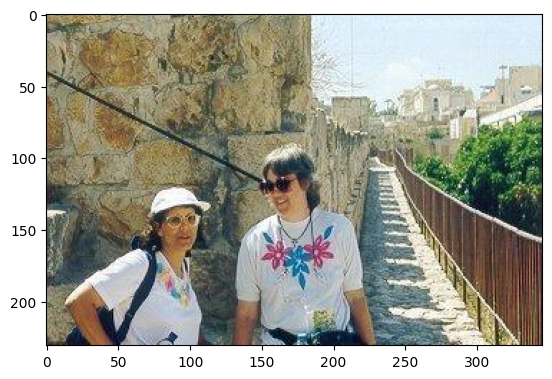

In [5]:


crop_size = 480
padding = [0.0] * 3
image = Image.open(img_path)
image = np.array(image)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)
image = transform(image).unsqueeze(0)
img = image[0].permute(1,2,0)
img = img * 0.5 + 0.5
plt.imshow(img)

In [6]:
#args.label_src = 'person,other'
#args.label_src = 'plant,grass,cat,stone,other'
args.label_src = label_str

In [7]:
labels = []
print('** Input label value: {} **'.format(args.label_src))
lines = args.label_src.split(',')
for line in lines:
    label = line
    labels.append(label)

with torch.no_grad():
    outputs = evaluator.parallel_forward(image, labels) #evaluator.forward(image, labels) #parallel_forward
    #outputs = model(image,labels)
    predicts = [
        torch.max(output, 1)[1].cpu().numpy() 
        for output in outputs
    ]
#Lseg results    
predict = predicts[0]

** Input label value: person,other **
** MultiEvalModule parallel_forward phase: ['person', 'other'] **
** MultiEvalModule forward phase: ['person', 'other'] **


C:\Users\bater\anaconda3\envs\lseg37\lib\site-packages\torch\nn\functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


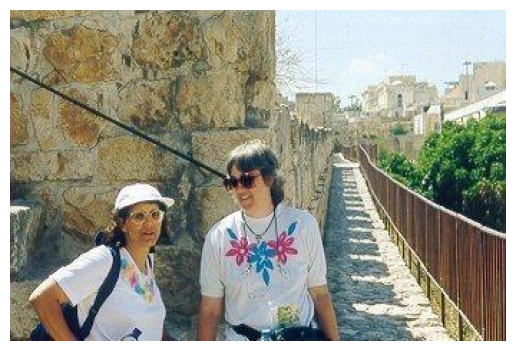

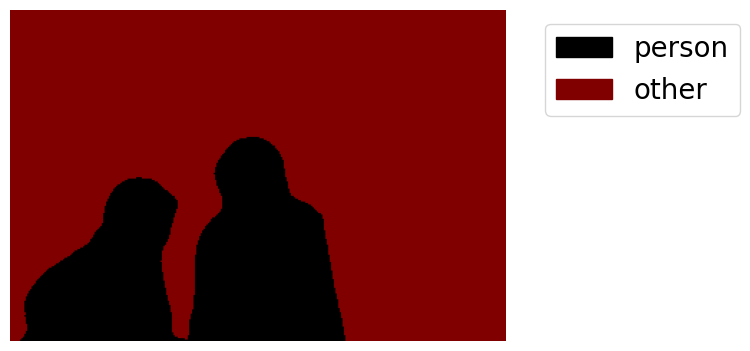

In [8]:

new_palette = get_new_pallete(len(labels))
mask, patches = get_new_mask_pallete(predict, new_palette, out_label_flag=True, labels=labels)
img = image[0].permute(1,2,0)
img = img * 0.5 + 0.5
img = Image.fromarray(np.uint8(255*img)).convert("RGBA")
seg = mask.convert("RGBA")
out = Image.blend(img, seg, alpha)
plt.axis('off')
plt.imshow(img)
plt.figure()
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
plt.axis('off')
plt.imshow(seg)

<h2> 2. Bounding Box Instancing </h2>


In [9]:
#Draw Rectangle on input canvas
def draw_rectangle(draw, coordinates, color, width=1):
    for i in range(width):
        rect_start = (coordinates[0][0] - i, coordinates[0][1] - i)
        rect_end = (coordinates[1][0] + i, coordinates[1][1] + i)
        draw.rectangle((rect_start, rect_end), outline = color)
#Compare if pixel A and B are the same, return true if same
def comparePixel(pxA,pxB):
    for i in range(len(pxA)):
       # print(type(pxA))
       # print(type(pxB))
        if pxA[i] != pxB[i]:
            return False
    return True

In [10]:
#Convert the palette used in lseg into rgba for easier computation
def palette_to_rgba(new_palette):
    colors = [] 
    for i in range(2,len(new_palette),3): #new_pallete is a contiguous tuple of rgb values
        colors.append([new_palette[i-2],new_palette[i-1],new_palette[i]])
    rgba_cols = []
    for color in colors:
        color.append(255)
        rgba_cols.append(np.array(color))
    return rgba_cols #colors of each label for the segmap
#Break the singular segmap into multiple maps for each input label, and generate a single bounding box for each label
#Each generated segmap will have transparency for pixels that are not of the label
def process_segmap(rgba_cols, seg):
    bboxes = []
    segmaps = []

    for rgba_col in rgba_cols:
        test_seg = np.array(seg).copy()
        xmin = ymin = 99999
        xmax = ymax = 0
        #separate the segments, put in a larger loop for each label
        for col in range(0,len(test_seg)):
            #print(row)
            for row in range(0,len(test_seg[col])):
                if not comparePixel(test_seg[col][row],rgba_col):
                    test_seg[col][row] = [0,0,0,0] #make transparent
                else: #get top left and bottom right to draw rectangle
                    if row>xmax:
                        xmax = row
                    if col>ymax:
                        ymax = col
                    if row<xmin:
                        xmin = row
                    if col<ymin:
                        ymin = col
        bboxes.append([xmin,ymin,xmax,ymax])
        segmaps.append(test_seg)
    return bboxes, segmaps
    #Image.fromarray(test_seg)

In [11]:
rgba_cols = palette_to_rgba(new_palette)
bboxes, segmaps = process_segmap(rgba_cols,seg)

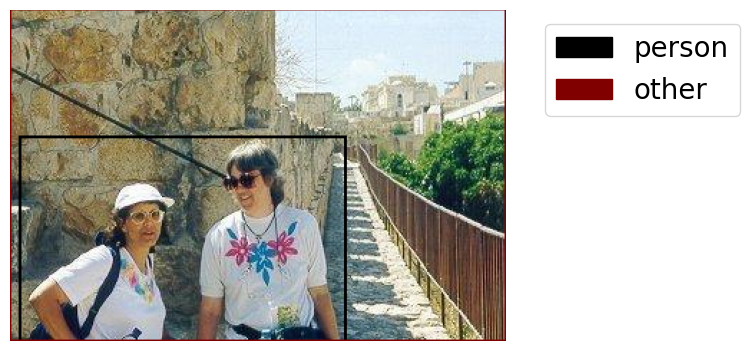

In [12]:
#Show results of bounding boxes
from PIL import Image, ImageDraw
img_copy = img.copy()
for i in range(0,len(bboxes)): #the other BBOX got bug, so minus 1
    topLeft = (bboxes[i][0],bboxes[i][1])
    bottomRight = (bboxes[i][2],bboxes[i][3])
    img1 = ImageDraw.Draw(img_copy)
    #rect_color = getHexColor(rgba_cols[i])
    draw_rectangle(img1, (topLeft,bottomRight),color = tuple(rgba_cols[i]), width=2)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
plt.axis('off')
plt.imshow(img_copy)

In [13]:
#Function to find the gap within the existing bounding box
#Returns 2 arrays indicating the range or horizontal gap and vertical gap
#Values in the array can be used to identify how to split the bounding boxes
#Eg. Return value [sx1,sx2] indicates the split starts from x=sx1, y=y and ends at x=sx2, y=y

def contiguous_transparency_scan(box,segmap,instance_threshold=0):
    #iterative vertical scan (left to right scan every column)
    min_x = max_x = -1
    for x in range(box[0],box[2]):
        isContiguous = True #whether it is a contiguous transparent block
        count_colored = 0
        for y in range(box[1],box[3]):
            #print(x,y)
            if not comparePixel(segmap[y][x],[0,0,0,0]):
                count_colored+=1
                if count_colored>instance_threshold:
                    isContiguous = False
                    break
        if isContiguous:
            #print(x)
            if min_x==-1:
                min_x = x
                max_x = min_x
            else:
                max_x +=1
        else:
            if max_x - min_x > 0:
                break
    #iterative horizontal scan (top to bottom scan every row)
    min_y = max_y = -1
    for y in range(box[1],box[3]):
        isContiguous = True
        count_colored = 0
        for x in range(box[0],box[2]):
            if not comparePixel(segmap[y][x],[0,0,0,0]):
                count_colored+=1
                if count_colored>=instance_threshold:
                    isContiguous = False
                    break
                #isContiguous = False
                #break
        if isContiguous:
            if min_y==-1:
                min_y = y
                max_y = min_y
            else:
                max_y +=1
        else:
            if max_y - min_y > 0:
                break
    #if max_x - min_x>0 or arbitary threshold means there is a gap in the segmentation
    # if the above is true, that means the bounding box can be instanced into a left and right instance
    # if max_y - min_y >0 or arbitary threshold, means thee boundingbox can be instanced into a top and bottom instance
    return [min_x,max_x],[min_y,max_y]


In [14]:
#Optimize the new boxes to fit nicely around the segment instance, split bounding boxes tend to be larger than segment
def optimizeBoxes(bbox,segmap):
    new_boxes = []

    for box in bbox:
        xmin = ymin = 99999
        xmax = ymax = 0
        for col in range(box[0],box[2]):
            for row in range(box[1],box[3]):
                if not comparePixel(segmap[row][col], [0,0,0,0]):
                    if col>xmax:
                        xmax = col
                    if row>ymax:
                        ymax = row
                    if col<xmin:
                        xmin = col
                    if row<ymin:
                        ymin = row
        if [xmin,ymin,xmax,ymax] != [99999,99999,0,0]:
            new_boxes.append([xmin,ymin,xmax,ymax])
        else:
            new_boxes.append(box)

    return new_boxes

#Split boxes and optimize
def splitBox(box,x_split, y_split, segmap):
    bbox = []
    if x_split[0]==-1 and y_split[0]==-1:
        return
    elif x_split[0]==-1:
        #splt top and bottom
        top_box = [box[0],y_split[0],box[2],box[3]]
        bot_box = [box[0],box[1],box[2],y_split[1]]
        #bbox = [top_box,bot_box]
        bbox = optimizeBoxes([top_box,bot_box],segmap)
    else:
        #split left and right
        left_box = [box[0],box[1],x_split[0],box[3]]
        right_box = [x_split[1],box[1],box[2],box[3]]
        #bbox = [left_box,right_box]
        bbox = optimizeBoxes([left_box,right_box],segmap)
    return bbox

In [15]:
#Return box size in area
def boxSize(box):
    x = box[2]-box[0]
    y = box[3]-box[1]
    return x*y

def boxSize_xywh(box):
    return box[2]*box[3]

#Return max similarity value for each variable
def boxSimilarity(box1,box2):
    x1 = abs(box2[0]-box1[0])
    y1 = abs(box2[1]-box1[1])
    x2 = abs(box2[2]-box1[2])
    y2 = abs(box2[3]-box1[3])
    return max([x1,y1,x2,y2])

In [16]:
#Main function to instance the segmentation map based on horizontal and verticle gaps, as well as optimize the size
#boxes that are too similar or too small are also filtered out along the way
def bbox_instancing(bboxes,segmaps,min_size = 5):
    final_instances = []
    for idx in range(len(bboxes)): #number of classes
        box = bboxes[idx]
        segmap = segmaps[idx]

        box_instances = []
        instanced_boxes = [box]
        i = 0
        #iteratively instance boxes repeatedly until boxes cannot be instanced further
        while(i<len(instanced_boxes)):
            x_contiguous,y_contiguous = contiguous_transparency_scan(instanced_boxes[i],segmap,instance_threshold=0)
            #x_contiguous,y_contiguous = segmap_instancing(instanced_boxes[i],segmap,instance_threshold=0)
            print (x_contiguous)
            new_bboxes = splitBox(instanced_boxes[i],x_contiguous,y_contiguous,segmap)
            #print(new_bboxes)
            if new_bboxes != None:
                new_count = 0
                instanced_boxes.pop(i) #remove the box that got split into 2 instances first
                i-=1
                for new_box in new_bboxes:
                    #append the instances only if it meets the minimum size requirement
                    if boxSize(new_box)>min_size:
                        instanced_boxes.append(new_box)
                        new_count+=1
                #if new_count>0: #if at least one new box is added

            i+=1
        #filter out similar boxes that are adjacent
        i=0
        while(i<len(instanced_boxes)-1):

            sim = boxSimilarity(instanced_boxes[i],instanced_boxes[i+1])
            if (sim<5): #too similar
                print(instanced_boxes[i],instanced_boxes[i+1])
                # remove smaller box
                if boxSize(instanced_boxes[i])>boxSize(instanced_boxes[i+1]):
                    instanced_boxes.pop(i+1)
                else:
                    instanced_boxes.pop(i)
                i-=1
            i+=1
        final_instances.append(instanced_boxes)
    return final_instances

In [17]:
w,h = img.size
min_size = w*h*0.005 #arbitary min size, 0.005 for the cat human image
new_bbox = bbox_instancing(bboxes,segmaps,min_size=min_size) 
new_bbox

[7, 9]
[117, 123]
[9, 9]
[-1, -1]
[-1, -1]
[-1, -1]


[[[124, 89, 231, 228], [10, 117, 115, 227]], [[0, 0, 345, 230]]]

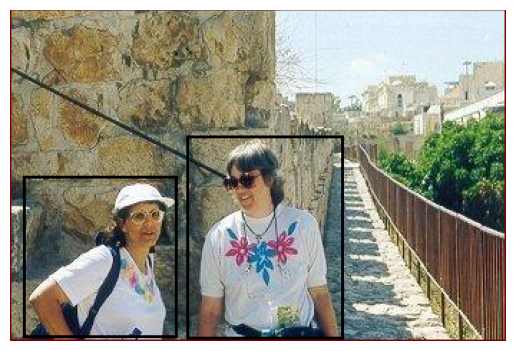

In [18]:
#sample bbox instancing result
from PIL import Image, ImageDraw
img_copy_test = img.copy()
for i in range(len(new_bbox)):
    for j in range(len(new_bbox[i])):
        topLeft = (new_bbox[i][j][0],new_bbox[i][j][1])
        bottomRight = (new_bbox[i][j][2],new_bbox[i][j][3])
        img1 = ImageDraw.Draw(img_copy_test)
        #rect_color = getHexColor(rgba_cols[i])
        draw_rectangle(img1, (topLeft,bottomRight),color = tuple(rgba_cols[i]), width=2)
        #draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
plt.axis('off')
plt.imshow(img_copy_test)

<h2>3. Visual Grounding Module </h2>

In [19]:
#label probs seem to be the scores, and it seem to work 
#use "other" as the other label. blue is abit iffy, but white works
#maybe return more than 1 bounding boxes
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [20]:
#Preliminary Bounding box selection
img_copy_clip = Image.open(img_path)
print(type(img_copy_clip))
img_copy_clip = np.array(img_copy_clip)

cropped_imgs = [[]]

for cls in range(len(new_bbox)-1):
    for bbox in new_bbox[cls]:
        #print(bbox)
        cropped_imgs[cls].append(Image.fromarray(img_copy_clip[bbox[1]:bbox[3],bbox[0]:bbox[2]]))
    

metric_threshold = 0.0001 #return all boxes within 0.1 of the max score
preliminary_ret_index = []
for i in range(len(cropped_imgs)): #ignore the "other" class
    max_score = 0
    ret_index_temp = []
    ret_index_cls = []
    for j in range(len(cropped_imgs[i])): #for each cropped_image run it through clip with the label of description and get the highest scoring boxes
        #image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
        image = preprocess(cropped_imgs[i][j]).unsqueeze(0).to(device)
        #text = clip.tokenize(["person in blue", "person in white", "person in red"]).to(device)
        text = clip.tokenize([user_input, "other"]).to(device)  #extracted input is also based on class
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)

            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        print("Label probs:", probs) 
        #if score is higher than max, max = score and append to list. if score within 0.1 of max score, append as well
        if probs[0][0]>max_score:
            max_score = probs[0][0]
            ret_index_temp.append([j,probs[0][0]])
        elif max_score-probs[0][0] <=metric_threshold:
            ret_index_temp.append([j,probs[0][0]])
    #filter out scores with a greater difference than 0.1 from max score, and add the results to ret_index_cls
    for j in range(len(ret_index_temp)):
        if max_score - ret_index_temp[j][1] <= metric_threshold:
            ret_index_cls.append(ret_index_temp[j][0])
    preliminary_ret_index.append(ret_index_cls) #final return indices for all classes
        #probs[0][0]
preliminary_ret_index

<class 'PIL.JpegImagePlugin.JpegImageFile'>
Label probs: [[0.7983 0.2018]]
Label probs: [[0.887  0.1128]]


[[1]]

In [21]:

import sys
import cv2


# If image path and f/q is not passed as command
# line arguments, quit and display help message
#if len(sys.argv) < 3:
#    print(__doc__)
#    sys.exit(1)
def ssearch(img_path, bboxes):
    rects = []
    for bbox in bboxes: #use this for pre-instanced bboxes
        # speed-up using multithreads
        cv2.setUseOptimized(True);
        cv2.setNumThreads(4);
        top_left = (bbox[0],bbox[1])
        # read image
        im = cv2.imread(img_path)[bbox[1]:bbox[3],bbox[0]:bbox[2]]
        #cv2.imshow("test", im)
        #print(im)

        # create Selective Search Segmentation Object using default parameters
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

        # set input image on which we will run segmentation
        ss.setBaseImage(im)


        ss.switchToSelectiveSearchQuality()


        # run selective search segmentation on input image
        temp_rects = ss.process() #xywh
        for rect in temp_rects:
            if boxSize_xywh(rect)>min_size: #remove box if too small
                temp_rect = [0,0,0,0]
                temp_rect[0] = rect[0]+top_left[0]
                temp_rect[1] = rect[1]+top_left[1]
                temp_rect[2] = temp_rect[0]+rect[2]
                temp_rect[3] = temp_rect[1]+rect[3]
                rects.append(temp_rect)
        print('Total Number of Region Proposals: {}'.format(len(rects)))


    # number of region proposals to show
    numShowRects = 100
    # increment to increase/decrease total number
    # of reason proposals to be shown
    increment = 50
    return rects

Total Number of Region Proposals: 345
Input: person in a cap


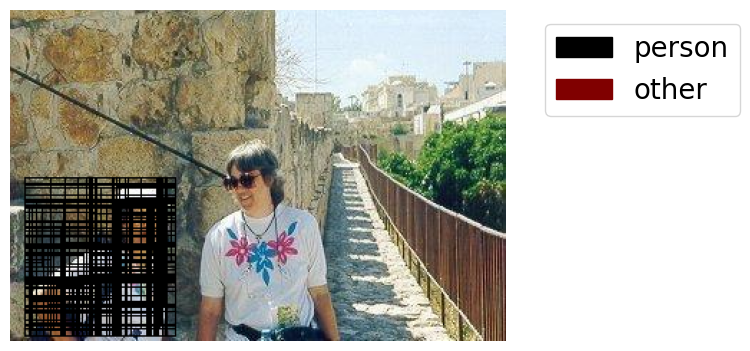

In [22]:
#Region Proposal Algorithm
prop_rects = ssearch(img_path, [new_bbox[0][preliminary_ret_index[0][0]]]) #uninstanced bboxes
img_copy_test = Image.open(img_path)
#print(prop_rects)
count = 0
for rect in prop_rects:
    topLeft = (rect[0],rect[1])
    bottomRight = (rect[2],rect[3])
    img1 = ImageDraw.Draw(img_copy_test)
    draw_rectangle(img1, (topLeft,bottomRight),color = tuple(rgba_cols[0]), width=1)
    count+=1
    if count>1000:
        break
plt.axis('off')
plt.imshow(img_copy_test)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
print("Input: "+user_input)
#bboxes

In [23]:
processed_new_bbox = new_bbox.copy()

In [24]:
crop_size = 480
padding = [0.0] * 3
img_copy_clip = Image.open(img_path)
img_copy_clip = np.array(img_copy_clip)


cropped_imgs = [[]]

#for bbox in prop_rects:
    #print(bbox)
#    cropped_imgs[0].append(Image.fromarray(img_copy_clip[bbox[1]:bbox[3],bbox[0]:bbox[2]]))


In [29]:
metric_threshold = 0.0001 #return all boxes within 0.00001 of the max score
final_ret_index = []
max_score = 0
ret_index_temp = []
ret_index_cls = []
box_id = 0
for bbox in prop_rects: #ignore the "other" class
    image = preprocess(Image.fromarray(img_copy_clip[bbox[1]:bbox[3],bbox[0]:bbox[2]])).unsqueeze(0).to(device)
    #text = clip.tokenize(["person in blue", "person in white", "person in red"]).to(device)
    text = clip.tokenize([user_input, "other"]).to(device)  #extracted input is also based on class
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    print("Box "+str(box_id), probs[0][0]) 
    #if score is higher than max, max = score and append to list. if score within threshold of max score, append as well
    if probs[0][0]>max_score:
        max_score = probs[0][0]
        ret_index_temp.append([box_id,probs[0][0]])
    elif max_score-probs[0][0] <=metric_threshold:
        ret_index_temp.append([box_id,probs[0][0]])
    
    box_id+=1
#filter out scores with a greater difference than 0.1 from max score, and add the results to ret_index_cls
for j in range(len(ret_index_temp)):
    if max_score - ret_index_temp[j][1] <= metric_threshold:
        ret_index_cls.append(ret_index_temp[j][0])
final_ret_index.append(ret_index_cls) #final return indices for all classes
    #probs[0][0]
final_ret_index 

Box 0 0.725
Box 1 0.4727
Box 2 0.585
Box 3 0.3345
Box 4 0.0995
Box 5 0.887
Box 6 0.923
Box 7 0.539
Box 8 0.3452
Box 9 0.304
Box 10 0.5312
Box 11 0.8887
Box 12 0.3108
Box 13 0.4187
Box 14 0.2147
Box 15 0.291
Box 16 0.734
Box 17 0.3108
Box 18 0.22
Box 19 0.3174
Box 20 0.9824
Box 21 0.4534
Box 22 0.37
Box 23 0.899
Box 24 0.3074
Box 25 0.3345
Box 26 0.4148
Box 27 0.2815
Box 28 0.3008
Box 29 0.2815
Box 30 0.793
Box 31 0.89
Box 32 0.916
Box 33 0.1755
Box 34 0.8975
Box 35 0.2878
Box 36 0.8965
Box 37 0.8823
Box 38 0.1755
Box 39 0.906
Box 40 0.4072
Box 41 0.9546
Box 42 0.2095
Box 43 0.331
Box 44 0.2281
Box 45 0.2018
Box 46 0.3923
Box 47 0.4648
Box 48 0.1943
Box 49 0.1919
Box 50 0.15
Box 51 0.946
Box 52 0.2878
Box 53 0.9336
Box 54 0.3074
Box 55 0.4072
Box 56 0.881
Box 57 0.899
Box 58 0.461
Box 59 0.231
Box 60 0.496
Box 61 0.3074
Box 62 0.314
Box 63 0.2095
Box 64 0.2281
Box 65 0.2568
Box 66 0.4072
Box 67 0.5547
Box 68 0.461
Box 69 0.3345
Box 70 0.4417
Box 71 0.434
Box 72 0.22
Box 73 0.4226
Box 74

[[20, 329]]

CLIP Metric Threshold:  0.0001
Input: person in a cap


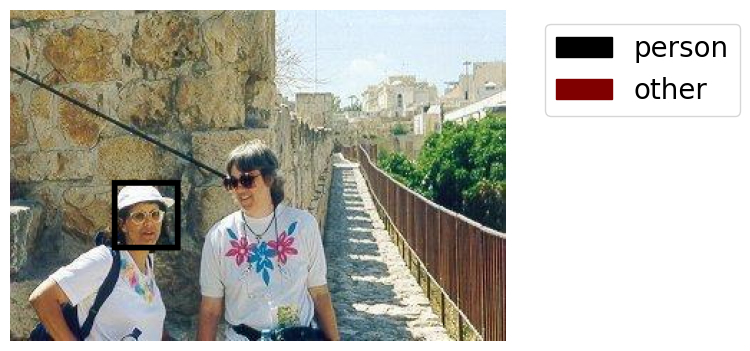

In [30]:
#draw results from clip
from PIL import Image, ImageDraw
img_copy_test = img.copy()

idx = final_ret_index[0][0]
#print((processed_new_bbox[i][j]))
topLeft = (prop_rects[idx][0],prop_rects[idx][1])
bottomRight = (prop_rects[idx][2],prop_rects[idx][3])
img2 = ImageDraw.Draw(img_copy_test)
#rect_color = getHexColor(rgba_cols[i])
draw_rectangle(img2, (topLeft,bottomRight),color = tuple(rgba_cols[i]), width=4)
#draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
plt.axis('off')
plt.imshow(img_copy_test)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
print("CLIP Metric Threshold: ",metric_threshold)
print("Input: "+user_input)

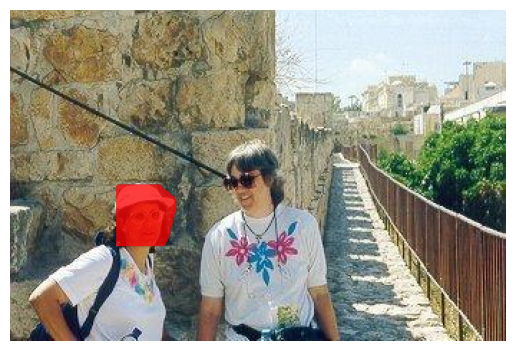

In [31]:
def in_bbox(bbox,x,y):
    if x>=bbox[0] and x<=bbox[2]:#(bbox[0] + bbox[2]):
        if y>=bbox[1] and y<=bbox[3]:#(bbox[1] + bbox[3]):
            return True
    return False
new_map = segmaps[0].copy()
new_bbox_xywh = prop_rects[idx]
for y in range(len(new_map)):
    for x in range(len(new_map[y])):
        if not in_bbox(new_bbox_xywh,x,y):
            new_map[y][x] = [0,0,0,0]

#change color
for y in range(len(new_map)):
    for x in range(len(new_map[y])):
        if not np.all(new_map[y][x]==[0,0,0,0]):
            new_map[y][x] = [255,0,0,128]

img_copy_new = img.copy()
mask_image1 = Image.fromarray(new_map)
composite_image = Image.alpha_composite(img_copy_new.convert("RGBA"), mask_image1.convert("RGBA"))
plt.axis('off')
plt.imshow(composite_image)
plt.axis('off')
plt.imshow(new_map)